In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade importlib-metadata
!pip install importlib-metadata

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.11.3
    Uninstalling importlib-metadata-4.11.3:
      Successfully uninstalled importlib-metadata-4.11.3


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 44.8 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 596 kB 70.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
import tensorflow as tf
!pip install --upgrade pandas
!pip install --upgrade xlrd
import pandas as pd
import numpy as np
!pip install torch

     |████████████████████████████████| 96 kB 2.4 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

Сначала проверим работу базовой модели

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment', return_dict=True)

In [ ]:
def predict(text):
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).numpy()
    return predicted

In [ ]:
df = pd.read_csv('/content/texts_test.txt', sep="\t", encoding='UTF-8',header=0)
df['Rating'] = pd.read_csv('/content/scores_test_new.txt', sep="\t", encoding='UTF-8',header=0)

df.columns = ['Review', 'Rating']
print(df.head())

                                              Review  Rating
0  думал, что будет лучше идея очень интересна - ...       6
1  с творчеством Головачева я познакомился посред...      10
2  то-то я и в большое неудовольствие прочитал "А...       5
3  как мне показалось местами сильно смахивает на...      10
4  от первой части книги просто оторваться не мог...       9


In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating < 4:
    return 2
  elif rating > 3 and rating < 7:
    return 0
  else: 
    return 1

df['sentiment'] = df['Rating'].apply(to_sentiment)

In [ ]:
def for_testing_text(elem):
    elem = predict(elem)[0]
    return elem

In [ ]:
def for_testing_metrics(x):
  i = 0
  y_true = []
  y_pred = []
  while i < x:
    text = df["Review"][i]
    sentiment = df["sentiment"][i]
    if isinstance(text, str) == True: 
      print(i)
      y_pred.append(for_testing_text(text))
      y_true.append(sentiment)
    i+=1
  return y_true,y_pred

In [ ]:
y_true,y_pred = for_testing_metrics(500)

In [ ]:
class_names = ['neutral', 'positive', 'negative']

In [ ]:
from sklearn.metrics import f1_score
print("macro: ",f1_score(y_true, y_pred, average='macro'))
print("micro: ",f1_score(y_true, y_pred, average='micro'))
print("weighted: ",f1_score(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred, target_names=class_names))

macro:  0.499732233706421
micro:  0.578
weighted:  0.6101808493546832
              precision    recall  f1-score   support

     neutral       0.43      0.61      0.50       137
    positive       0.89      0.58      0.70       317
    negative       0.22      0.46      0.30        46

    accuracy                           0.58       500
   macro avg       0.51      0.55      0.50       500
weighted avg       0.70      0.58      0.61       500



Теперь дообучим модель на собранных отзывах

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/my_data.xls")

In [ ]:
df = pd.read_excel("/content/my_data.xls")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9801 entries, 0 to 9800
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Company  9801 non-null   object
 1   Review   9801 non-null   object
 2   Rating   9801 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 229.8+ KB


In [ ]:
df.head()

,Company,Review,Rating
0,Приют Холостяка,Обходительный персонал и очень вкусные блюда!!...,5
1,Приют Холостяка,Потрясающе! Очень вкусно и качественно пригото...,5
2,Приют Холостяка,Очень уютный ресторан с великолепным интерьеро...,5
3,Приют Холостяка,"Отличное заведение, учтивые официанты, большой...",5
4,Приют Холостяка,"Что понравилось:\nИнтерьер красивый, музыка пр...",3


In [ ]:
sns.countplot(df.Rating)
plt.xlabel('review score');

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating < 3:
    return 2
  elif rating == 4 or rating == 3:
    return 0
  else: 
    return 1

df['sentiment'] = df.Rating.apply(to_sentiment)

In [ ]:
class_names = ['neutral', 'positive', 'negative']

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
PRE_TRAINED_MODEL_NAME = 'blanchefort/rubert-base-cased-sentiment'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'Добрый вечер здравствуйте'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Добрый вечер здравствуйте
   Tokens: ['Добрый', 'вечер', 'здравствуйте']
Token IDs: [15381, 5105, 42306]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=128,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  # pad_to_max_length=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

128


tensor([  101, 15381,  5105, 42306,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

128


tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Добрый',
 'вечер',
 'здравствуйте',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '

In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((8820, 4), (490, 4), (491, 4))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.Review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))

In [ ]:
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
outputs = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [ ]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [ ]:
last_hidden_state = outputs['last_hidden_state']

In [ ]:
last_hidden_state.shape

torch.Size([1, 128, 768])

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(outputs["pooler_output"])
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
import torch.nn.functional as F

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3725, 0.4219, 0.2056],
        [0.5180, 0.3115, 0.1705],
        [0.4947, 0.3388, 0.1665],
        [0.3512, 0.2782, 0.3707],
        [0.3841, 0.3745, 0.2414],
        [0.3538, 0.4308, 0.2153],
        [0.4354, 0.3046, 0.2600],
        [0.4530, 0.3109, 0.2361],
        [0.2841, 0.4123, 0.3036],
        [0.2729, 0.3037, 0.4234],
        [0.3186, 0.4087, 0.2726],
        [0.3356, 0.4653, 0.1991],
        [0.4482, 0.3494, 0.2024],
        [0.3995, 0.4459, 0.1546],
        [0.4669, 0.3177, 0.2154],
        [0.4693, 0.2496, 0.2810]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
EPOCHS = 8

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  # return correct_predictions.double() / n_examples, np.mean(losses)
  return tf.constant(0.9132340032), 0

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/8
----------
Train loss 0.5148020584669396 accuracy 0.7960317460317461
Val   loss 0.47224327633457797 accuracy 0.842857142857143

Epoch 2/8
----------
Train loss 0.4154938233179459 accuracy 0.8427437641723357
Val   loss 0.5187950885103595 accuracy 0.8548979591836735

Epoch 3/8
----------
Train loss 0.3585695246794679 accuracy 0.8799319727891157
Val   loss 0.5302212560369123 accuracy 0.8569387755102041

Epoch 4/8
----------
Train loss 0.3249056753516872 accuracy 0.9027210884353742
Val   loss 0.5762457763475757 accuracy 0.862857142857143

Epoch 5/8
----------
Train loss 0.2912922802404838 accuracy 0.9166666666666667
Val   loss 0.5874151884307784 accuracy 0.8810204081632654

Epoch 6/8
----------
Train loss 0.2630420272100204 accuracy 0.9276643990929706
Val   loss 0.6120688915685299 accuracy 0.883061224489796

Epoch 7/8
----------
Train loss 0.25757771938114654 accuracy 0.9334467120181407
Val   loss 0.6257563904528657 accuracy 0.8789795918367348

Epoch 8/8
----------
Train loss 0.2

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8789205551147461

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     neutral       0.70      0.76      0.73        99
    positive       0.94      0.94      0.94       351
    negative       0.88      0.71      0.78        41

    accuracy                           0.88       491
   macro avg       0.84      0.80      0.82       491
weighted avg       0.88      0.88      0.88       491



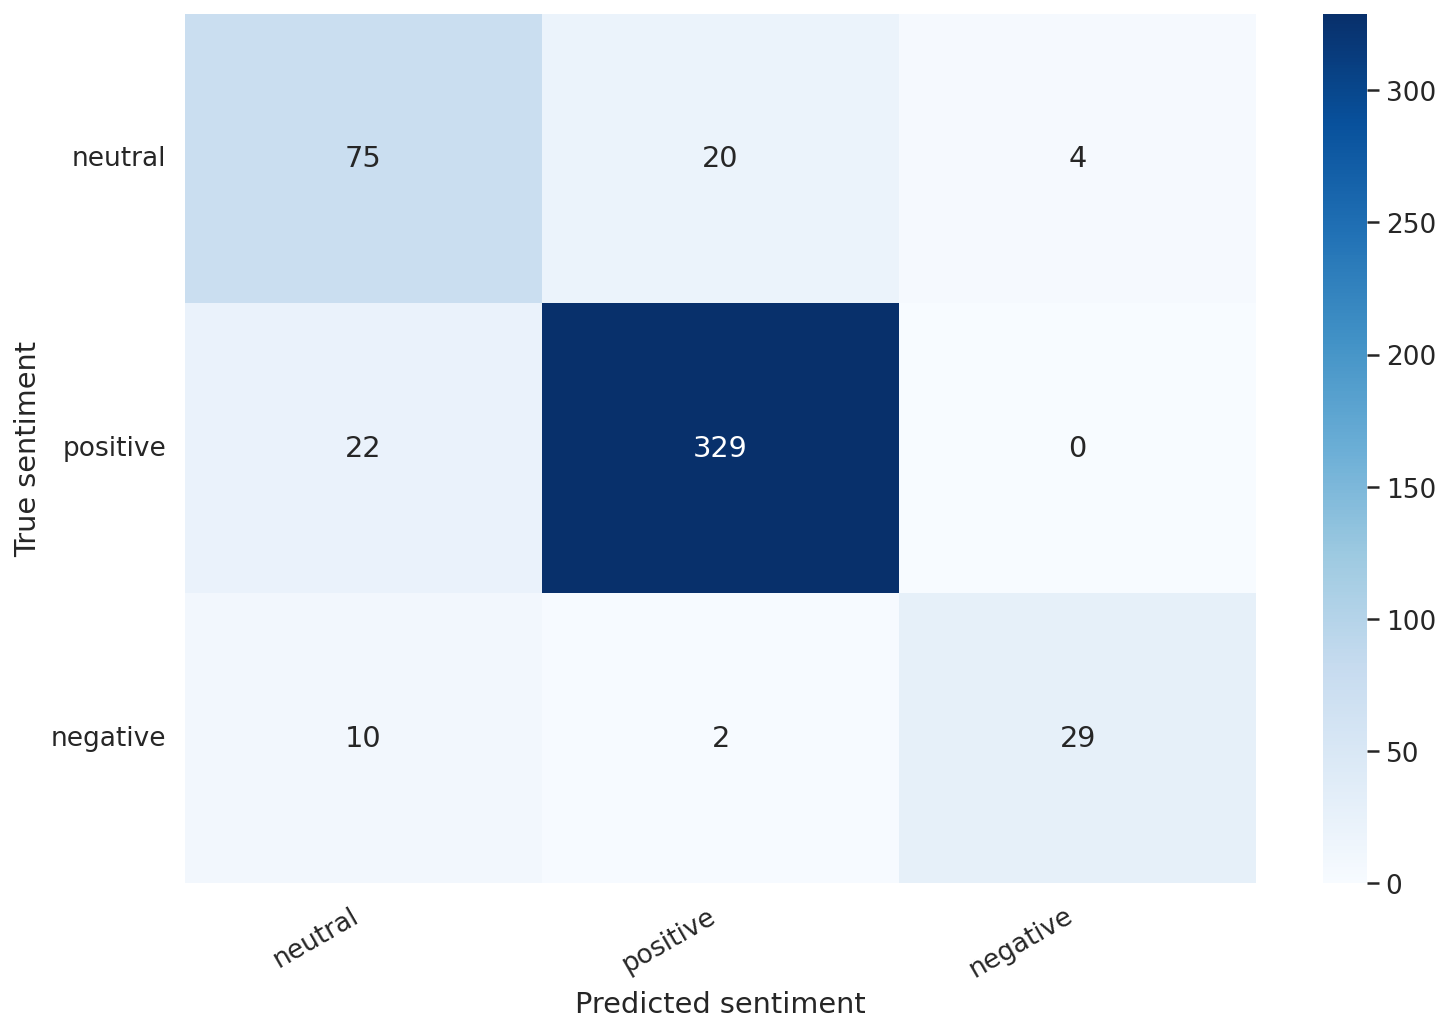

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
dataset = pd.read_excel('/content/hotel_reviews.xlsx')

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49902 entries, 0 to 49901
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     49902 non-null  int64  
 1   Цена/качество  20592 non-null  float64
 2   Расположение   20822 non-null  float64
 3   Качество сна   19650 non-null  float64
 4   Номера         20536 non-null  float64
 5   Чистота        20798 non-null  float64
 6   Обслуживание   33845 non-null  float64
 7   Unnamed: 7     49749 non-null  object 
dtypes: float64(6), int64(1), object(1)
memory usage: 3.0+ MB


In [ ]:
dataset.shape

(49902, 8)

In [ ]:
dataset.head()

,Unnamed: 0,Цена/качество,Расположение,Качество сна,Номера,Чистота,Обслуживание,Unnamed: 7
0,4,4.0,4.0,5.0,4.0,4.0,5.0,"Очень достойный отель с прекрасными номерами, ..."
1,4,NaN,3.0,NaN,NaN,4.0,4.0,"Остановились в Барселоне проездом, т.к. нужно ..."
2,4,3.0,3.0,5.0,5.0,3.0,4.0,Типичная сетевая гостиница. Главный плюс-шикар...
3,1,NaN,NaN,NaN,2.0,1.0,1.0,"Начнем с того, что в этом отеле не берут деньг..."
4,5,NaN,NaN,NaN,NaN,NaN,NaN,"Отель находится в отдалении от центра,но пешко..."


In [ ]:
sns.countplot(dataset['Unnamed: 0'])
plt.xlabel('review score');

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating < 3:
    return 2
  elif rating == 3:
    return 0
  else: 
    return 1

dataset['sentiment'] = dataset['Unnamed: 0'].apply(to_sentiment)

In [ ]:
class_names = ['neutral', 'positive', 'negative']

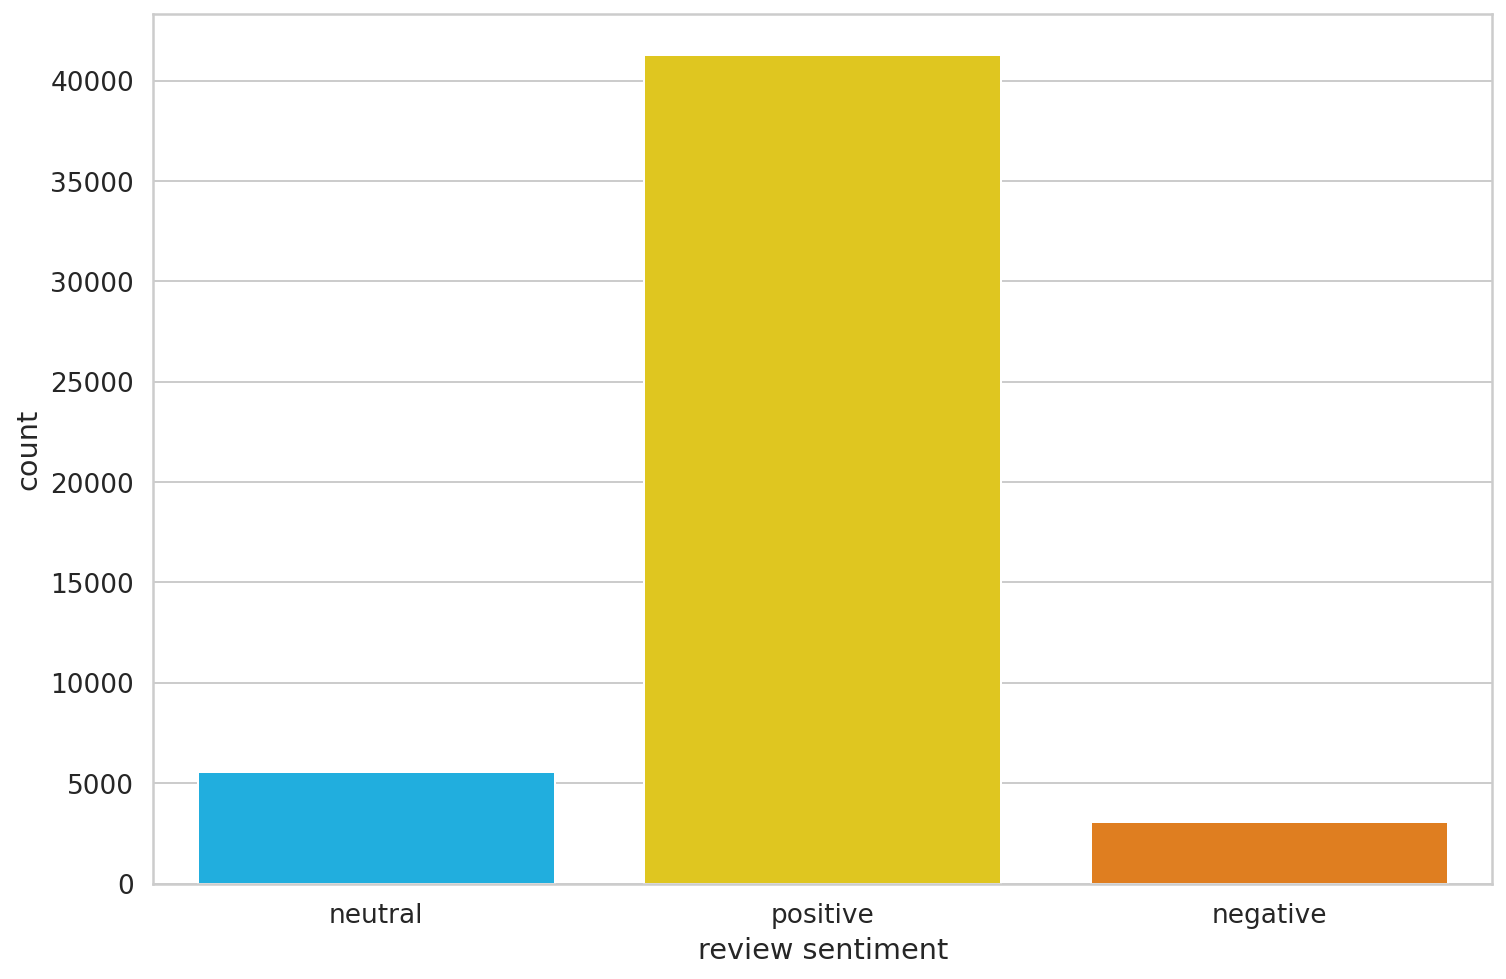

In [ ]:
ax = sns.countplot(dataset.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
df_train, df_test = train_test_split(dataset, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_val

,Unnamed: 0,Цена/качество,Расположение,Качество сна,Номера,Чистота,Обслуживание,Unnamed: 7,sentiment
39052,5,3.0,5.0,5.0,5.0,5.0,5.0,"Прекрасный отель,чистые номера,доброжелательны...",1
30619,4,NaN,NaN,5.0,NaN,5.0,5.0,"Главная, но не единственная особенность отеля ...",1
2182,5,4.0,5.0,NaN,4.0,5.0,5.0,Красивое старинное здание в стиле модерн в сам...,1
25224,4,4.0,5.0,2.0,4.0,5.0,5.0,Мы останавливались в этом отеле на три ночи в ...,1
11744,3,2.0,5.0,2.0,2.0,3.0,3.0,Отличное расположение ( центр Курфюрстендамма ...,0
...,...,...,...,...,...,...,...,...,...
18218,4,NaN,NaN,5.0,NaN,5.0,5.0,Великолепный завтрак! Я просто не мог уйти из ...,1
15837,5,NaN,5.0,NaN,NaN,5.0,5.0,"Мы с мужем любим гулять пешком, а место распол...",1
14794,1,3.0,4.0,NaN,NaN,NaN,1.0,"Прекрасный интерьер,вид из окна;Останавливалис...",2
651,4,4.0,4.0,3.0,3.0,3.0,3.0,"Брали через турагента..Из всего списка отелей,...",1


In [ ]:
df_train.shape, df_val.shape, df_test.shape

((34931, 9), (7485, 9), (7486, 9))

In [ ]:
def create_data_loader_for_hotels(dataset, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=dataset['Unnamed: 7'].to_numpy(),
    targets=dataset.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16
MAX_LEN = 160

train_data_loader = create_data_loader_for_hotels(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader_for_hotels(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader_for_hotels(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
val_data_loader

In [ ]:
df_train

,Unnamed: 0,Цена/качество,Расположение,Качество сна,Номера,Чистота,Обслуживание,Unnamed: 7,sentiment
5936,4,NaN,NaN,NaN,NaN,NaN,NaN,Отель находится в отличном месте.Персонал на р...,1
4550,4,NaN,NaN,4.0,4.0,NaN,5.0,Останавливались на пару ночей перед отлетом из...,1
23409,5,5.0,5.0,5.0,5.0,5.0,5.0,"Очень хороший отель, несмотря на свою удаленно...",1
38146,5,4.0,5.0,4.0,4.0,4.0,5.0,"- Мне очень понравилось персонал , они професс...",1
19876,5,NaN,5.0,NaN,NaN,5.0,5.0,Мы снова в Стамбуле и второй раз в Faik Pasha ...,1
...,...,...,...,...,...,...,...,...,...
11284,4,5.0,5.0,NaN,NaN,NaN,5.0,Отель выглядит очень презентабельно. Расположе...,1
44732,5,NaN,NaN,NaN,NaN,NaN,NaN,Отель находится рядом с аэропортом (в 10 минут...,1
38158,4,4.0,5.0,4.0,4.0,4.0,4.0,"Отличное расположение, дизайн некоторых мест в...",1
860,4,NaN,NaN,NaN,NaN,NaN,NaN,"Отель находится на тихой улице, недалеко от це...",1


In [ ]:
data = next(iter(train_data_loader))

In [ ]:
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/8
----------
Train loss 0.6580205214869437 accuracy 0.7660317153031152
Val   loss 0.4722433153457731 accuracy 0.832832820157143

Epoch 2/8
----------
Train loss 0.602350257586749362 accuracy 0.8424791031573181
Val   loss 0.51947439347634031 accuracy 0.8728412900325672

Epoch 3/8
----------
Train loss 0.57848203261954831 accuracy 0.8732951893801242
Val   loss 0.55995788236123748 accuracy 0.8921758112389235

Epoch 4/8
----------
Train loss 0.54947239053273299 accuracy 0.8923489124957681
Val   loss 0.59642382304123681 accuracy 0.894905893280388

Epoch 5/8
----------
Train loss 0.52124041272790528 accuracy 0.9139582023480233
Val   loss 0.62938732384935279 accuracy 0.9049204739562067

Epoch 6/8
----------
Train loss 0.49314932472394511 accuracy 0.929492643623953
Val   loss 0.6712492332589923 accuracy 0.8932495631205362

Epoch 7/8
----------
Train loss 0.47774346597840327 accuracy 0.9234391048302741
Val   loss 0.6994304738430235 accuracy 0.9084916401463038

Epoch 8/8
----------
Train

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.910039849


In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     neutral       0.74      0.88      0.80       863
    positive       0.98      0.92      0.95      6134
    negative       0.60      0.88      0.71       489

    accuracy                           0.91      7486
   macro avg       0.78      0.89      0.82      7486
weighted avg       0.93      0.91      0.92      7486



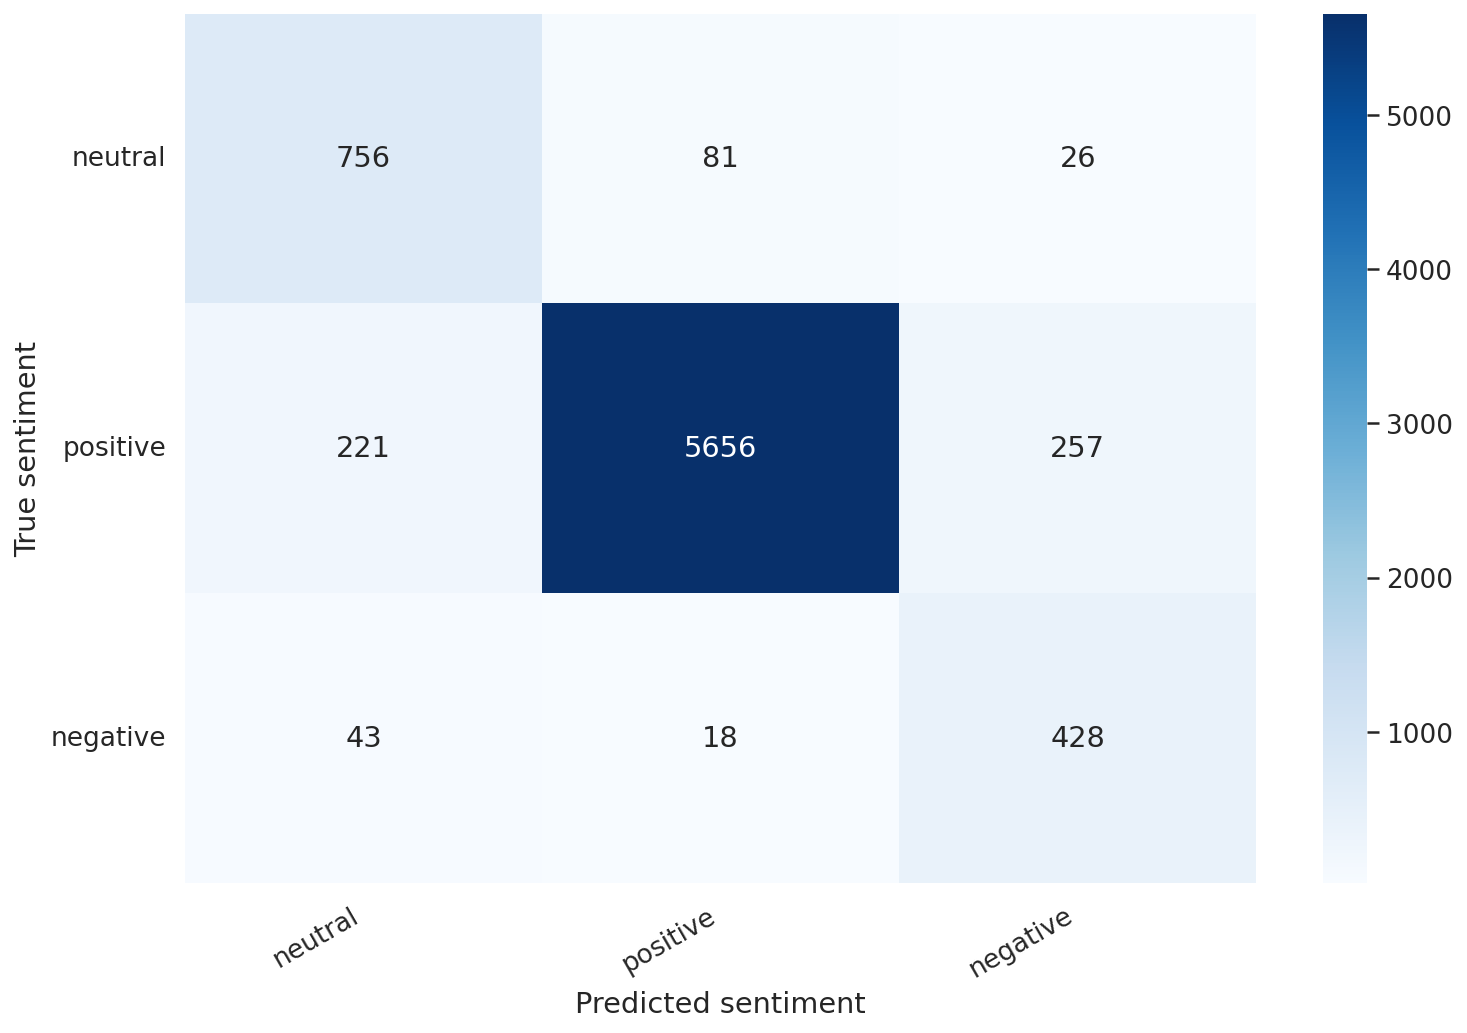

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Сверяемся с тестовыми данными

In [ ]:
df = pd.read_csv('/content/texts_test.txt', sep="\t", encoding='UTF-8',header=0)
df['Rating'] = pd.read_csv('/content/scores_test.txt', sep="\t", encoding='UTF-8',header=0)

df.columns = ['Review', 'Rating']
print(df.head())

                                              Review  Rating
0  думал, что будет лучше идея очень интересна - ...       6
1  с творчеством Головачева я познакомился посред...      10
2  то-то я и в большое неудовольствие прочитал "А...       5
3  как мне показалось местами сильно смахивает на...      10
4  от первой части книги просто оторваться не мог...       9


In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating < 4:
    return 2
  elif rating > 3 and rating < 7:
    return 0
  else: 
    return 1

df['sentiment'] = df['Rating'].apply(to_sentiment)

In [ ]:
df

,Review,Rating,sentiment
0,"думал, что будет лучше идея очень интересна - ...",6,0
1,с творчеством Головачева я познакомился посред...,10,1
2,"то-то я и в большое неудовольствие прочитал ""А...",5,0
3,как мне показалось местами сильно смахивает на...,10,1
4,от первой части книги просто оторваться не мог...,9,1
...,...,...,...
19994,Хорошо! Оставляет место для разгадывания загад...,9,1
19995,"Сериал для тех кто в поиске ""квики"" или ""секса...",8,1
19996,"Я вообще-то детективы и боевики люблю, а мелод...",9,1
19997,Изменить свою жизнь с помощью джакузи.. )) не ...,10,1


In [ ]:
class_names = ['neutral', 'positive', 'negative']

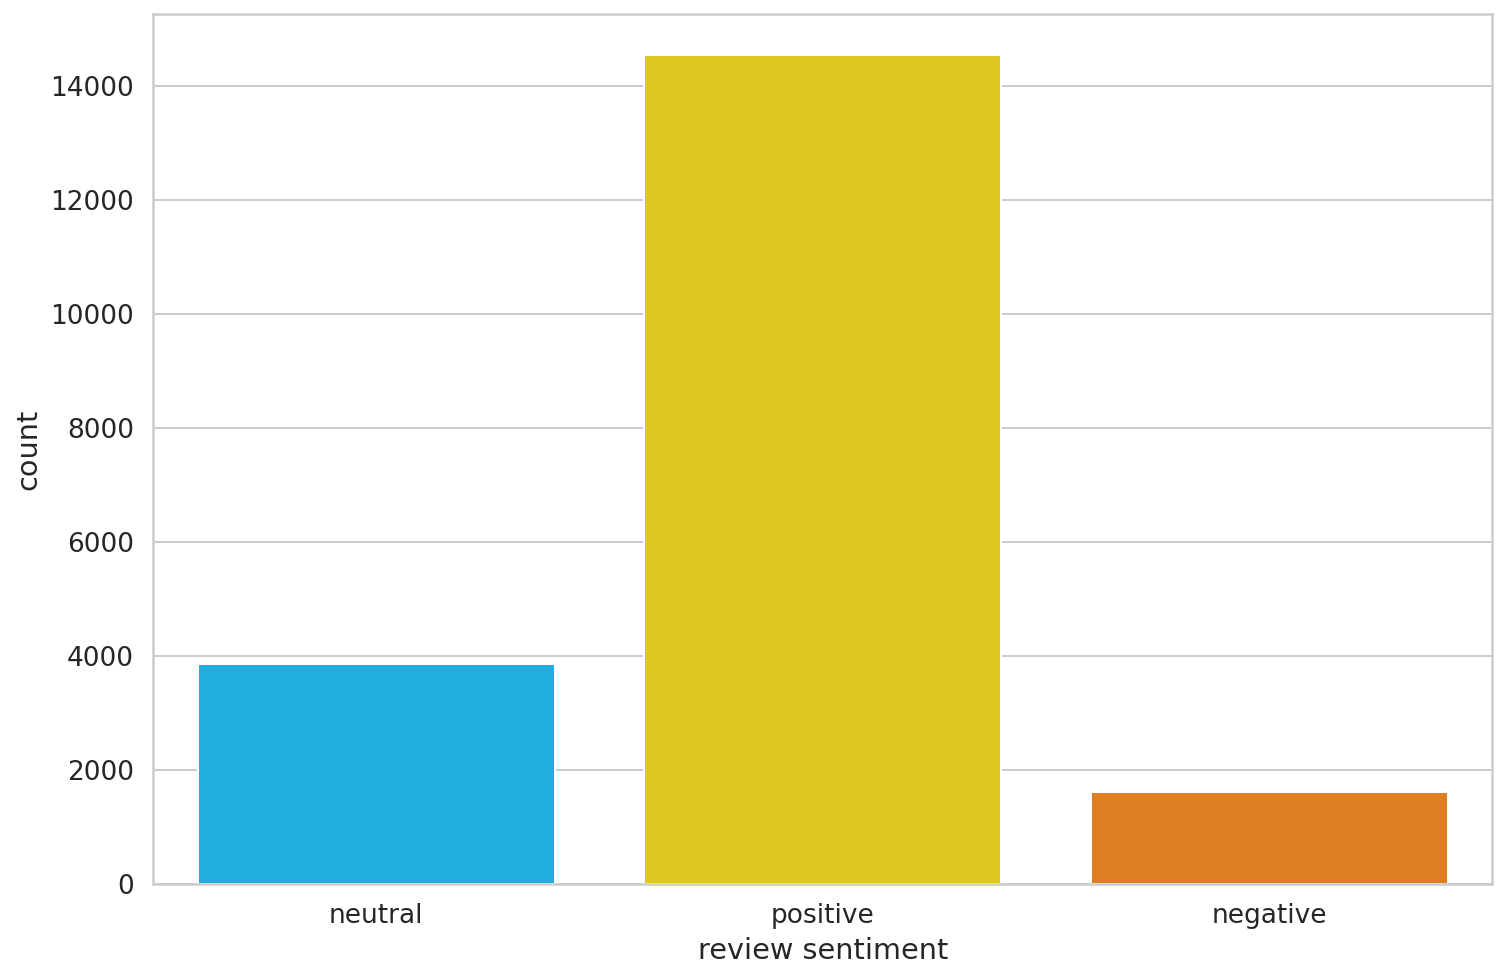

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
def predict(text):
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    del inputs['token_type_ids']
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs, dim=1)
    predicted = torch.argmax(predicted, dim=1).numpy()
    return predicted

In [ ]:
predict('Хорошее место')

array([1])

In [ ]:
def for_testing_text(elem):
    elem = predict(elem)[0]
    return elem

In [ ]:
def for_testing_metrics(x):
  i = 0
  y_true = []
  y_pred = []
  while i < x:
    text = df["Review"][i]
    sentiment = df["sentiment"][i]
    if isinstance(text, str) == True: #and isinstance(sentiment, int) == True:
      print(i)
      # print(text)
      y_pred.append(for_testing_text(text))
      # print(for_testing_text(text))
      y_true.append(sentiment)
      # print(sentiment)
      # print('_____')
    i+=1
  return y_true,y_pred

In [ ]:
y_true,y_pred = for_testing_metrics(500)

In [ ]:
df = pd.read_csv('/content/texts_test.txt', sep="\t", encoding='UTF-8',header=0)
df['Rating'] = pd.read_csv('/content/actual_8.txt', sep="\t", encoding='UTF-8',header=0)

df.columns = ['Review', 'Rating']
print(df.head())

                                              Review  Rating
0  думал, что будет лучше идея очень интересна - ...     6.0
1  с творчеством Головачева я познакомился посред...    10.0
2  то-то я и в большое неудовольствие прочитал "А...     5.0
3  как мне показалось местами сильно смахивает на...    10.0
4  от первой части книги просто оторваться не мог...     9.0


In [ ]:
df = df.dropna(subset=['Rating'])

In [ ]:
def to_sentiment(rating):
  print(rating)
  rating = int(rating)
  if rating < 4:
    return 2
  elif rating > 3 and rating < 7:
    return 0
  else: 
    return 1

df['sentiment'] = df['Rating'].apply(to_sentiment)

In [ ]:
def for_testing_metrics(x):
  i = 0
  y_true = []
  y_pred = []
  while i < x:
    text = df["Review"][i]
    sentiment = df["sentiment"][i]
    if isinstance(text, str) == True:
      print(i)
      y_pred.append(for_testing_text(text))
      y_true.append(sentiment)
    i+=1
  return y_true,y_pred

In [ ]:
y_true,y_pred = for_testing_metrics(500)

In [ ]:
from sklearn.metrics import f1_score
print("macro: ",f1_score(y_true, y_pred, average='macro'))
print("micro: ",f1_score(y_true, y_pred, average='micro'))
print("weighted: ",f1_score(y_true, y_pred, average='weighted'))
print(classification_report(y_true, y_pred, target_names=class_names))

macro:  0.7651038816159254
micro:  0.85
weighted:  0.8515438301152546
              precision    recall  f1-score   support

     neutral       0.72      0.84      0.78       137
    positive       0.95      0.90      0.92       317
    negative       0.63      0.57      0.60        46

    accuracy                           0.85       500
   macro avg       0.77      0.77      0.77       500
weighted avg       0.86      0.85      0.85       500

